<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-ML/blob/main/TCN_Noise_Cancellation_Single_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Real-Time Noise-Canceling Model for Audio Waveforms

### Objective:
The goal of this project is to develop a deep learning model capable of performing real-time noise cancellation on short audio samples. The model is designed to predict the phase-shifted signal, which, when combined with the original noisy input, results in near-silence. This task aims to provide effective noise suppression with low latency, making it suitable for real-time applications like active noise cancellation in headphones or live audio processing.


### Real-Time Considerations:
This model is optimized for real-time audio processing:
- **Small Sequence Length**: With a sequence length of only 16 samples, the model responds quickly to incoming audio, ensuring low-latency predictions, which are critical for real-time noise cancellation.
- **Causal Convolutions**: By maintaining causality, the model can be deployed in real-time settings where future data points are not available, making it suitable for streaming applications such as active noise cancellation in headphones or real-time audio editing.
  
Given the rapid convergence and minimal loss, the model can feasibly be deployed in real-time applications with further integration into audio capture and output pipelines, allowing it to suppress unwanted noise while preserving desired signals.

### Libraries installation

In [ ]:
# Install libraries
!pip install numpy matplotlib IPython tensorflow librosa scikit-learn

### Input Sound to train for cancellation. (Mono channel, 44.1Khz)

In [1]:
import librosa
from google.colab import files

def load_local_audio():
  uploaded = files.upload()
  for file_name in uploaded.keys():
      print(f"Uploaded file: {file_name}")
      audio, sr = librosa.load(file_name, sr=None)  # Load with original sample rate
      return audio, sr, file_name

# Step 1: Load the local audio
sample_input, sample_rate, file_name = load_local_audio()

# Get the duration in seconds
sample_duration = librosa.get_duration(y=sample_input, sr=sample_rate)

print(f"Loaded audio file: {file_name}")
print(f"Sample Rate: {sample_rate} Hz")
print(f"Duration: {sample_duration} seconds")

Saving extractor_44k.wav to extractor_44k.wav
Uploaded file: extractor_44k.wav
Loaded audio file: extractor_44k.wav
Sample Rate: 44100 Hz
Duration: 4.003469387755102 seconds


### Input Sound Analysis and Resampling for Optimized Model Training

In this section, we analyze the input sound's frequency content and resample it in a way that maximizes the efficiency of model training. The goal is to retain the majority of relevant audio information while reducing the computational load on the model by eliminating frequencies that contribute little to the overall signal energy.

#### Key Steps:

1. **Frequency Analysis using FFT (Fast Fourier Transform):**
   - The first step is to perform a **Fast Fourier Transform (FFT)** on the input audio. FFT converts the time-domain audio signal into the frequency domain, breaking it down into its individual frequency components.
   - From this transformation, we obtain the **frequencies** and their corresponding **magnitude** (or energy) that indicate how much each frequency contributes to the overall sound.

2. **Retaining Relevant Frequencies Based on Energy Contribution:**
   - Audio signals typically have a wide range of frequencies, but not all frequencies are equally important. A large portion of the audio's energy may be concentrated in a smaller range of frequencies.
   - We define a `desired_retention` percentage, which specifies the proportion of the audio's total energy we wish to retain in the resampled signal. In this case, 95% of the total energy is targeted for retention.
   - By calculating the **cumulative energy** from the sorted magnitude values of the frequency spectrum, we determine the **cutoff frequency**—the frequency below which the desired 95% of energy is concentrated. This is done by iterating over the sorted frequencies and calculating the cumulative percentage of the total energy until it reaches the retention target.

3. **Cutoff Frequency Determination:**
   - The cutoff frequency marks the upper limit of the frequency range that we will preserve in the resampling process. Frequencies higher than this cutoff contribute very little to the total energy and can therefore be safely discarded.
   - The Nyquist Theorem is applied to ensure that the new sample rate is sufficient to capture all important frequencies (up to the cutoff) without introducing aliasing. According to Nyquist, the sample rate should be at least **twice the cutoff frequency** to accurately represent the signal.

4. **Resampling the Audio:**
   - Once the cutoff frequency is calculated, we compute the new sample rate as `2 × cutoff frequency` and **resample** the audio to this new rate. Resampling reduces the number of samples per second, effectively lowering the model’s computational burden while preserving the majority of useful signal information.
   - The `resample_audio` function is used to perform this resampling operation, reducing the sample rate and the audio's total duration without significant loss in sound quality for the purposes of noise cancellation.

5. **Visualization of Cumulative Energy:**
   - A graph is generated to visualize the cumulative energy contribution of each frequency, with a vertical line indicating the cutoff frequency and a horizontal line showing the desired retention level. This provides an intuitive understanding of how the audio’s energy is distributed across frequencies and the impact of resampling.


#### Benefits for Model Training:

- **Reduced Computational Load**: By eliminating unnecessary high-frequency components, the input audio is resampled at a lower rate, reducing the number of samples the model needs to process.
- **Maintaining Audio Quality**: Despite reducing the sample rate, the majority of important frequencies are retained, ensuring that the sound quality is not significantly affected for the purposes of noise cancellation.
- **Optimized Training**: Fewer samples mean faster training times and reduced memory usage, while still providing the model with sufficient data to learn meaningful patterns from the audio.

This preprocessing technique ensures that the model receives high-quality, concise input data, helping to achieve faster convergence and better overall performance during training.

Cutoff frequency for 95% retention: 14871.85 Hz


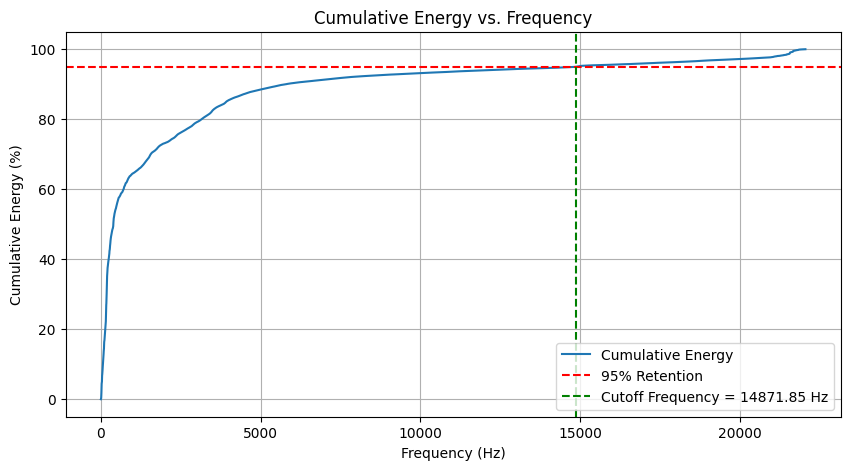

Rounded Cutoff Frequency: 14872 Hz
New Sample Rate: 29744 Hz
Resampled Duration: 4.003496503496503 seconds


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

desired_retention = 95  # Set the desired retention percentage

def calculate_cutoff_frequency(audio, sr, desired_retention):
    # Perform FFT (Fast Fourier Transform) to get frequency components
    fft = np.fft.fft(audio)
    frequencies = np.fft.fftfreq(len(fft), 1/sr)

    # Calculate the magnitude spectrum
    magnitude = np.abs(fft)

    # Filter positive frequencies only (since FFT is symmetric)
    positive_frequencies = frequencies[:len(frequencies)//2]
    magnitude = magnitude[:len(magnitude)//2]

    # Sort frequencies by magnitude (descending order of energy contribution)
    sorted_indices = np.argsort(positive_frequencies)
    sorted_frequencies = positive_frequencies[sorted_indices]
    sorted_magnitude = magnitude[sorted_indices]

    # Calculate cumulative energy of the signal
    cumulative_energy = np.cumsum(sorted_magnitude)
    total_energy = np.sum(sorted_magnitude)

    # Normalize the cumulative energy to a percentage
    cumulative_energy_percentage = (cumulative_energy / total_energy) * 100

    # Find the cutoff frequency where the desired retention is reached
    # Use argmax to find the closest index if 100% is not reached
    cutoff_index = np.argmax(cumulative_energy_percentage >= desired_retention)

    # If cutoff_index is 0 and desired_retention is not reached, use the last index
    if cutoff_index == 0 and cumulative_energy_percentage[cutoff_index] < desired_retention:
        cutoff_index = len(sorted_frequencies) - 1

    cutoff_frequency = sorted_frequencies[cutoff_index]

    print(f"Cutoff frequency for {desired_retention}% retention: {cutoff_frequency:.2f} Hz")

    # Plot the cumulative energy curve
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_frequencies, cumulative_energy_percentage, label="Cumulative Energy")
    plt.axhline(y=desired_retention, color='r', linestyle='--', label=f"{desired_retention}% Retention")
    plt.axvline(x=cutoff_frequency, color='g', linestyle='--', label=f"Cutoff Frequency = {cutoff_frequency:.2f} Hz")
    plt.title("Cumulative Energy vs. Frequency")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Cumulative Energy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return cutoff_frequency

def resample_audio(audio, original_sr, target_sr):
    # Resample the audio to the target sample rate
    resampled_audio = librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)
    return resampled_audio

cutoff_frequency = round(calculate_cutoff_frequency(sample_input, sample_rate, desired_retention))
print(f"Rounded Cutoff Frequency: {cutoff_frequency} Hz")

# Apply Nyquist Theorem: The new sample rate is calculated as 2 × cutoff frequency
# to ensure you capture all frequencies up to that cutoff without aliasing.
resampled_sr = int(np.ceil(2 * cutoff_frequency))
print(f"New Sample Rate: {resampled_sr} Hz")

# Resample the audio to the new sample rate
resampled_audio = resample_audio(sample_input, original_sr=sample_rate, target_sr=resampled_sr)
resampled_duration = librosa.get_duration(y=resampled_audio, sr=resampled_sr)
print(f"Resampled Duration: {resampled_duration} seconds")




### Model Architecture:
The model is based on **Temporal Convolutional Networks (TCN)**, which are well-suited for time-series predictions like audio waveforms. TCNs allow the model to learn from previous context without compromising real-time prediction capability, thanks to the use of causal convolutions. Causal convolutions ensure that predictions at time step `t` do not depend on future time steps, thus maintaining the causality needed for real-time processing.

#### Key Architectural Features:
- **Causal Conv1D Layers**: Three convolutional layers with causal padding and varying dilation rates are used to capture temporal patterns across multiple scales. This allows the model to have a large receptive field despite having a relatively low number of layers.
  - **Conv1D (filters=16, kernel_size=3, dilation_rate=1)**: The first layer captures immediate, local patterns in the waveform.
  - **Conv1D (filters=16, kernel_size=3, dilation_rate=2)**: The second layer with dilation rate 2 looks further into the past, capturing broader patterns.
  - **Conv1D (filters=32, kernel_size=3, dilation_rate=4)**: The third layer looks even further back, allowing the model to make predictions based on a wider temporal context.
  
- **Batch Normalization**: Applied after each convolutional layer to stabilize and speed up training by normalizing the activations. This prevents the model from getting stuck in poor local minima and improves generalization.

- **Dense Output Layer**: After flattening the final convolutional output, a dense layer with `tanh` activation produces a continuous output, representing the predicted phase-shifted waveform. The `tanh` activation is chosen to constrain the output between -1 and 1, which aligns with the normalized amplitude range of audio signals.

### Data Processing:
- **Sequence Length**: The model predicts based on a sequence length of 16 samples, meaning it considers the 16 most recent audio samples to make its prediction for the next sample. This choice provides a good balance between real-time responsiveness and the ability to capture useful temporal patterns.
  
- **Augmentation**: To make the model more robust and generalize well to real-world noisy environments, the input data is augmented with:
  - **Pitch Shifting**: Randomly altering the pitch of the audio to simulate varied acoustic conditions.
  - **Time Stretching**: Randomly slowing down or speeding up the audio to create different temporal contexts.
  These augmentations help the model learn to cancel noise in a variety of different scenarios.

### Optimizer and Training:
- **Adam Optimizer**: The model uses the Adam optimizer with an initial learning rate of 0.0005, which provides fast convergence while maintaining stability. Adam is well-suited for this task due to its adaptive learning rate mechanism, which adjusts the step size for each parameter individually.

- **Loss Function**: Mean Squared Error (MSE) is used as the loss function, as it is a standard choice for regression tasks where the goal is to minimize the difference between predicted and true continuous values.

- **Learning Rate Scheduler**: A `ReduceLROnPlateau` callback is employed to automatically reduce the learning rate when the model’s validation loss plateaus. This helps the model avoid overshooting the optimal solution and ensures better fine-tuning as training progresses.
  - **Patience**: 2 epochs
  - **Factor**: Learning rate is reduced by half (factor = 0.5) if validation loss doesn't improve for 2 consecutive epochs.
  - **Minimum Learning Rate**: 1e-6 to prevent over-reduction.

- **Early Stopping**: Early stopping is employed to avoid overfitting. Training halts if the validation loss does not improve for 2 consecutive epochs, restoring the best-performing weights from the training session.

In [3]:
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers, models

# Define the TCN model
# Learning rate for the optimizer (increase for faster learning)
learning_rate = 0.0005

# Number of previous samples to consider for prediction.
sequence_length = 16

def build_model():
    input_layer = layers.Input(shape=(sequence_length, 1))

    # First TCN block with optimized filters
    tcn = layers.Conv1D(filters=8, kernel_size=3, padding='causal', activation='relu', dilation_rate=1)(input_layer)
    tcn = layers.BatchNormalization()(tcn)
    tcn = layers.Conv1D(filters=8, kernel_size=3, padding='causal', activation='relu', dilation_rate=2)(tcn)
    tcn = layers.BatchNormalization()(tcn)

    # Second TCN block with reduced filter size
    tcn = layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu', dilation_rate=4)(tcn)
    tcn = layers.BatchNormalization()(tcn)

    # Flatten and dense layers with fewer units for faster inference
    flatten = layers.Flatten()(tcn)
    dense = layers.Dense(8, activation='relu')(flatten)  # Reduced to 8 units

    # Output layer to predict a single continuous value
    output_layer = layers.Dense(1, activation='tanh')(dense)

    # Compile model with reduced learning rate
    model = models.Model(inputs=input_layer, outputs=output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Reduced learning rate
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

def prepare_data(batch_size=32, validation_split=0.2):
    def augmented_wave_generator():
        while True:
            augmented_wave = augment_wave(resampled_audio, resampled_sr)
            for i in range(len(augmented_wave) - sequence_length):
                X = augmented_wave[i:i + sequence_length]
                y = -augmented_wave[i + sequence_length]
                yield X, y

    def validation_wave_generator():
        for i in range(len(resampled_audio) - sequence_length):
            X = resampled_audio[i:i + sequence_length]
            y = -resampled_audio[i + sequence_length]
            yield X, y

    train_dataset = tf.data.Dataset.from_generator(
        augmented_wave_generator,
        output_signature=(
            tf.TensorSpec(shape=(sequence_length,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    ).shuffle(1024).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_generator(
        validation_wave_generator,
        output_signature=(
            tf.TensorSpec(shape=(sequence_length,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    ).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

    steps_per_epoch = int((len(resampled_audio) - sequence_length) * (1 - validation_split) // batch_size)
    validation_steps = int((len(resampled_audio) - sequence_length) * validation_split // batch_size)

    return train_dataset, val_dataset, steps_per_epoch, validation_steps

def train(epochs=3, batch=32):
    train_dataset, val_dataset, steps_per_epoch, validation_steps = prepare_data(batch_size=batch)

    # Early stopping and learning rate reduction callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
        )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',   # Metric to monitor
        factor=0.5,           # Factor by which the learning rate will be reduced
        patience=2,           # Number of epochs with no improvement to wait before reducing LR
        min_lr=1e-6,           # Minimum learning rate to prevent over-reduction
        verbose=1
        )

    history = model.fit(
        train_dataset,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[lr_scheduler, early_stopping]
    )

    return history

# Augment the audio (time-stretching, pitch-shifting)
def augment_wave(wave, sample_rate):
    target_length = len(wave)

    # Apply random pitch shift with a smaller range
    pitch_shift = np.random.uniform(-0.5, 0.5)  # Reducing shift range
    wave_augmented = librosa.effects.pitch_shift(wave, sr=sample_rate, n_steps=pitch_shift)

    # Apply random time stretching with a smaller factor
    time_stretch_factor = np.random.uniform(0.9, 1.1)  # Reducing stretch factor
    wave_augmented = librosa.effects.time_stretch(wave_augmented, rate=time_stretch_factor)

    # Normalize augmented wave
    wave_augmented = librosa.util.normalize(wave_augmented)

    # Ensure the length matches the original wave length by padding or truncating
    if len(wave_augmented) > target_length:
        wave_augmented = wave_augmented[:target_length]
    else:
        # Calculate how much padding is needed
        padding_needed = target_length - len(wave_augmented)
        wave_augmented = np.concatenate((wave_augmented, wave[:padding_needed]))

    return wave_augmented


model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 8)             32        
                                                                 
 batch_normalization (Batch  (None, 16, 8)             32        
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 8)             200       
                                                                 
 batch_normalization_1 (Bat  (None, 16, 8)             32        
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 16)            400   

### Training Performance:
The model was trained on a dataset of audio waveforms, achieving excellent convergence across 3 epochs. The performance metrics indicate that the model is capable of producing high-quality predictions with very low error:

The final validation loss (MSE) of < **0.0005** indicates strong performance in predicting the phase-shifted waveform required for noise cancellation.

Epochs: 3
Batch Size: 16
Learning Rate: 0.0005
Sequence Length: 16
Epoch 1/3
5953/5953 [==============================] - 29s 4ms/step - loss: 0.0043 - mean_absolute_error: 0.0447 - val_loss: 0.0013 - val_mean_absolute_error: 0.0279 - lr: 5.0000e-04
Epoch 2/3
5953/5953 [==============================] - 26s 4ms/step - loss: 0.0011 - mean_absolute_error: 0.0242 - val_loss: 4.4100e-04 - val_mean_absolute_error: 0.0164 - lr: 5.0000e-04
Epoch 3/3
5953/5953 [==============================] - 25s 4ms/step - loss: 4.6869e-04 - mean_absolute_error: 0.0158 - val_loss: 2.1212e-04 - val_mean_absolute_error: 0.0113 - lr: 5.0000e-04
Finished training, testing predictions
3721/3721 [==============================] - 6s 2ms/step
Combined to Zero Validation Loss (MSE): 0.0002594567195046693


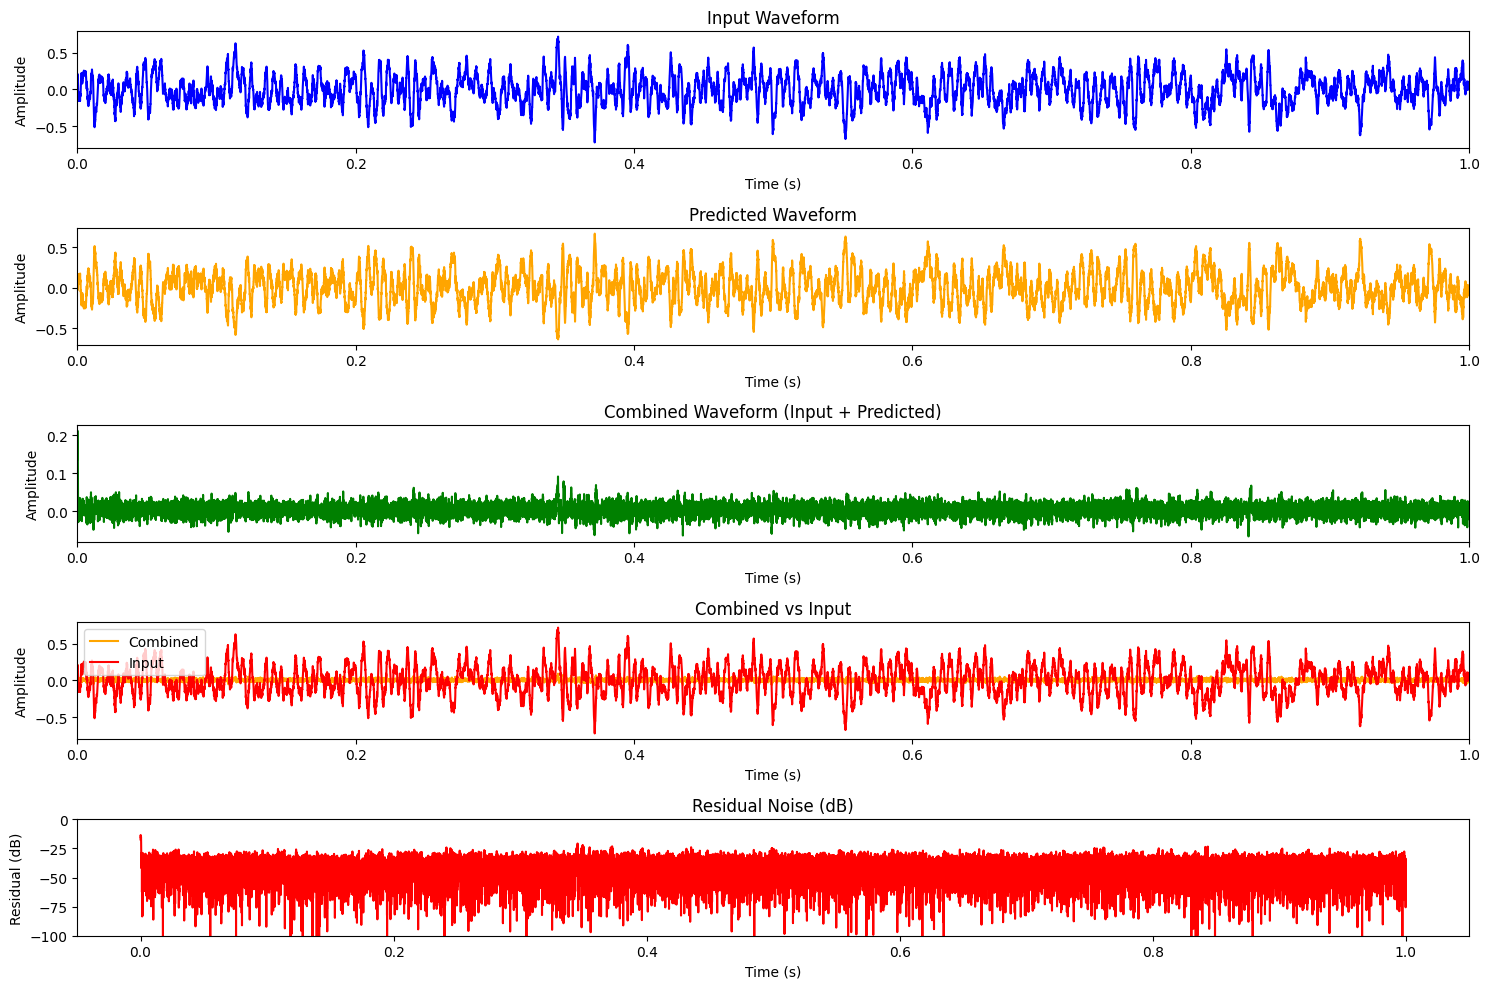

Test Input Waveform:
Predicted Inverted Waveform:
Combined Waveform:


In [4]:
def plot_results(test_waveform, predicted_waveform):
    time_axis = np.linspace(0, resampled_duration, int(resampled_sr * resampled_duration), endpoint=False)
    zoom_duration = 1.0  # 1s
    zoom_samples = int(resampled_sr * zoom_duration)

    #pad with 0 the missing initial sequence_length
    predicted_waveform = np.pad(predicted_waveform, (sequence_length, 0), mode='constant', constant_values=0)

    # Calculate combined waveform
    combined_waveform = test_waveform + predicted_waveform

    # Compare combined waveform to zero (silence target)
    silence_target = np.zeros_like(combined_waveform)
    validation_loss = mean_squared_error(silence_target, combined_waveform)

    print(f'Combined to Zero Validation Loss (MSE): {validation_loss}')

    plt.figure(figsize=(15, 10))

    plt.subplot(5, 1, 1)
    plt.title('Input Waveform')
    plt.plot(time_axis[:zoom_samples], test_waveform[:zoom_samples], color='blue')
    plt.xlim(0, zoom_duration)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(5, 1, 2)
    plt.title('Predicted Waveform')
    plt.plot(time_axis[:zoom_samples], predicted_waveform[:zoom_samples], color='orange')
    plt.xlim(0, zoom_duration)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(5, 1, 3)
    plt.title('Combined Waveform (Input + Predicted)')
    plt.plot(time_axis[:zoom_samples], combined_waveform[:zoom_samples], color='green')
    plt.xlim(0, zoom_duration)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(5, 1, 4)
    plt.title('Combined vs Input')
    plt.plot(time_axis[:zoom_samples], combined_waveform[:zoom_samples], color='orange', label='Combined')
    plt.plot(time_axis[:zoom_samples], test_waveform[:zoom_samples], color='red', label='Input')
    plt.xlim(0, zoom_duration)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    residuals = combined_waveform[:zoom_samples]
    residuals_db = 20 * np.log10(np.abs(residuals) + 1e-10)

    plt.subplot(5, 1, 5)
    plt.title('Residual Noise (dB)')
    plt.plot(time_axis[:zoom_samples], residuals_db, color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Residual (dB)')
    plt.ylim(-100, 0)

    plt.tight_layout()
    plt.show()

    # Provide audio playback
    print("Test Input Waveform:")
    display(Audio(test_waveform, rate=resampled_sr))
    print("Predicted Inverted Waveform:")
    display(Audio(predicted_waveform, rate=resampled_sr))
    print("Combined Waveform:")
    display(Audio(combined_waveform, rate=resampled_sr))

def predict(test_waveform):
    X_test = []
    for i in range(len(test_waveform) - sequence_length):
        X_test.append(test_waveform[i:i + sequence_length])
    X_test = np.array(X_test).reshape(len(X_test), sequence_length, 1)
    predicted_waveform = model.predict(X_test)
    return predicted_waveform.flatten()  # Ensure it returns a 1D array

epochs = 3
batch_size = 16
print(f"Epochs: {epochs}")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Sequence Length: {sequence_length}")

history = train(epochs, batch_size)
print("Finished training, testing predictions")
predicted_waveform = predict(resampled_audio)

# Plot results
plot_results(resampled_audio, predicted_waveform)


In noise cancellation tasks, especially when dealing with synthetic or real-world noises like urban noise or airplane cabin noise, the goal is to minimize the error between the predicted anti-noise and the actual noise, leading to effective noise reduction when combined.

Here’s a breakdown of what to aim for in terms of loss values:

### 1. **Target Loss Value:**
   - **Mean Squared Error (MSE)** is often used in such tasks, as it measures the average squared difference between the predicted and actual waveforms. For this scenario:
     - A **loss value below 0.001** indicates that the model is making highly precise predictions, with very small errors between the predicted anti-noise and the actual noise signal.
     - **Values between 0.001 and 0.01** may still represent good performance, especially if the noise has complex characteristics.
     - If the **loss is above 0.01**, the model’s performance might not be optimal, and further tuning or more training data may be necessary.
     - Aiming for **0.0001** to **0.0005** is ideal for achieving high-quality noise cancellation, especially in a controlled environment.

### 2. **Interpreting the Loss Values:**
   - **Lower loss** generally means that the model is better at matching the inverted waveform to cancel out the original noise.
   - However, **very low loss values** (e.g., below **0.0001**) might indicate overfitting to training data, meaning that the model might perform well during training but poorly with new, unseen noise patterns.

### 3. **Evaluation with Real-World Samples:**
   - It's crucial to evaluate the model not just based on training loss but also using **validation loss** with real-world noise samples, like the ones you plan to use in your predictions.
   - If the **validation loss** is close to the training loss (e.g., within **10-20%** difference), it indicates that the model generalizes well and will likely perform better with new sounds.

### 4. **Subjective Evaluation:**
   - Besides numerical loss, it's important to **listen to the output**:
     - The **combined waveform** should have a significantly reduced noise level when the anti-noise is applied.
     - It can be helpful to **plot the residual noise** in dB and observe the **reduction in amplitude** after applying the model’s output to the original noise.

### Summary:
   - Aim for an MSE loss between **0.0005** and **0.001** for effective noise cancellation.
   - Regularly check the **validation loss** to ensure the model is generalizing well.
   - Use **audio playback** and **visual plots** to assess the practical effectiveness of the model’s predictions.

By focusing on these loss values and subjective evaluation, you’ll be able to fine-tune your model for effective noise cancellation.

### Testing on Uploaded WAV File:
This section allows users to upload a WAV file, make predictions using the loaded TCN model, and visualize the results.

In [5]:
from google.colab import files

# Save model
model_path='tcn_noise_cancellation.keras'
model.save(model_path)

# Download locally
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Save the TensorFlow Model in ONNX Format
  Usefull for inference with Microsoft.ML.OnnxRuntime in C#

In [7]:
!pip install tf2onnx
import tf2onnx

# Define the path to save the ONNX model
onnx_model_path = "tcn_noise_cancellation.onnx"

# Convert the model to ONNX
spec = (tf.TensorSpec((None, 16, 1), tf.float32, name="input"),)  # Adjust based on your input shape
onnx_model_path='tcn_noise_cancellation.onnx'
output_path = tf2onnx.convert.from_keras(model, input_signature=spec, output_path=onnx_model_path)

# Download locally
files.download(onnx_model_path)

print(f"Model saved to {onnx_model_path}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved to tcn_noise_cancellation.onnx


In [9]:
def load_model(path=model_path):
    model = models.load_model(path)
    print(f"Model loaded from {path}")

# Test with a local WAV file
load_model()

# Upload WAV file
uploaded = files.upload()
wav_filename = list(uploaded.keys())[0]


Model loaded from tcn_noise_cancellation.keras


Saving Motor-5-240671-A-44.wav to Motor-5-240671-A-44.wav


3445/3445 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Combined to Zero Validation Loss (MSE): 0.0011733974097296596


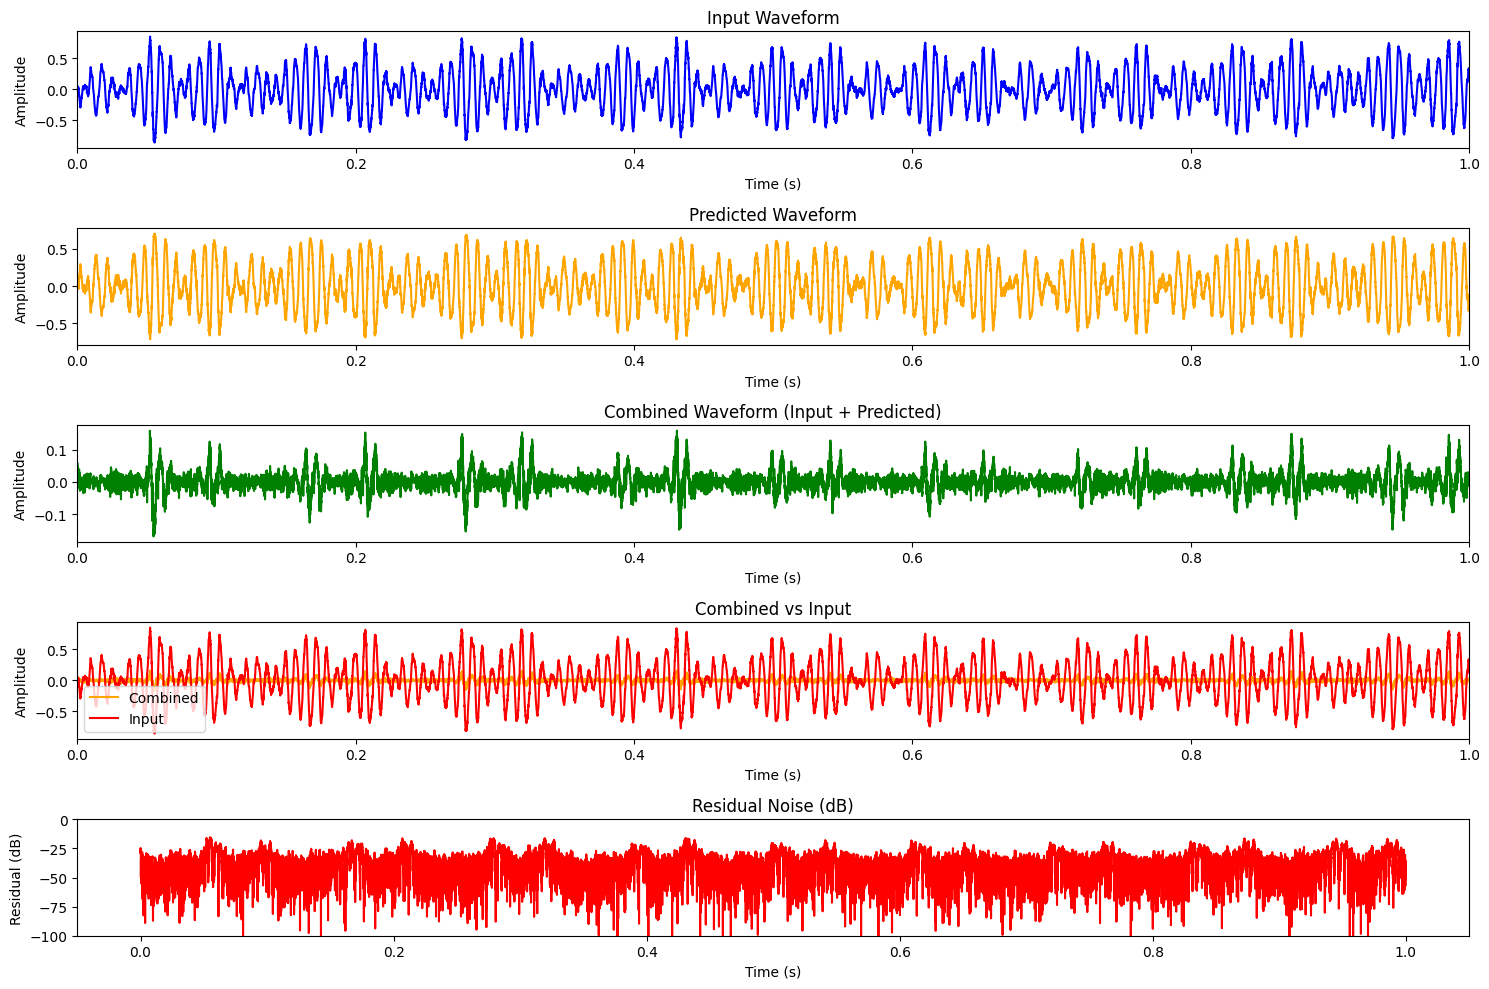

Test Input Waveform:


Predicted Inverted Waveform:


Combined Waveform:


In [12]:
def test_with_wav(wav_path):
    test_waveform, _ = librosa.load(wav_path)
    # Normalize the test waveform to [-1, 1] if needed
    test_waveform = test_waveform / np.max(np.abs(test_waveform))
    # Make predictions with the model
    predicted_waveform = predict(test_waveform)
    # Plot results
    plot_results(test_waveform, predicted_waveform)

test_with_wav(wav_filename)

### Show Model Architecture

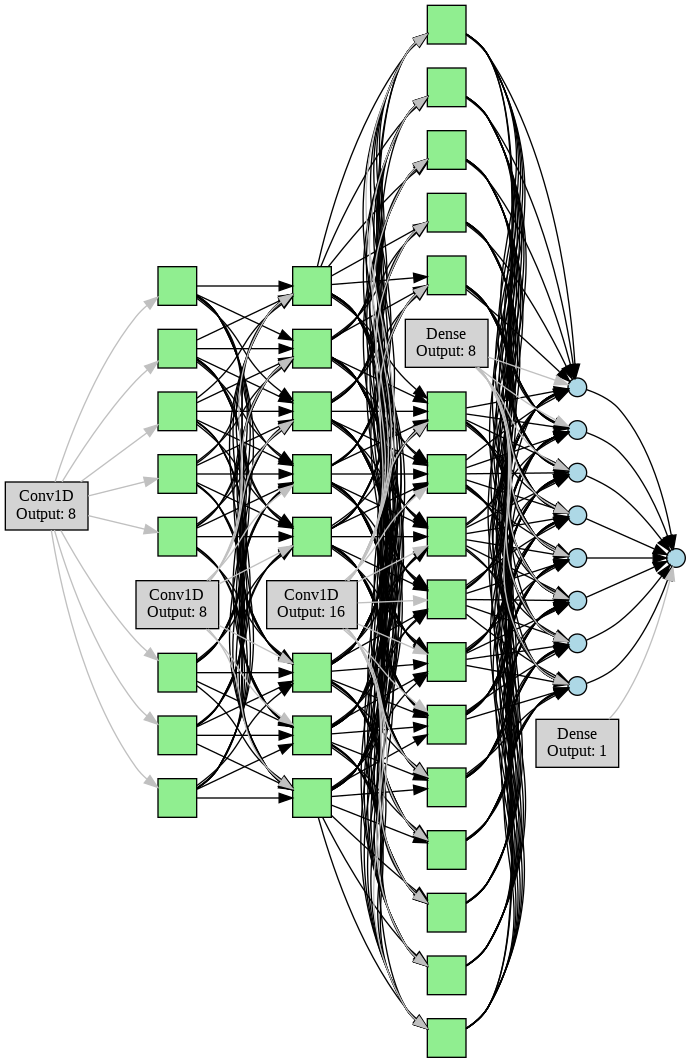

In [8]:
!apt-get -qq install -y graphviz && pip install pydot

import pydot
from IPython.display import Image, display
from tensorflow.keras import models, layers

def visualize_neural_network_from_model(model):
    """
    Visualizes a neural network structure given a Keras model.

    Parameters:
    model (tf.keras.Model): A compiled Keras model.
    """
    # Extract the number of neurons per layer along with the layer type and output shape
    layers_info = []
    for layer in model.layers:
        # Extract relevant information based on layer type
        layer_type = layer.__class__.__name__
        if hasattr(layer, 'units'):  # Dense layers
            layers_info.append((layer.units, layer_type))
        elif hasattr(layer, 'filters'):  # Conv1D layers
            layers_info.append((layer.filters, layer_type))
        elif hasattr(layer, 'output_shape') and isinstance(layer.output_shape, tuple):
            # Use the output shape's last dimension for non-Dense, non-Conv layers
            layers_info.append((layer.output_shape[-1], layer_type))

    # Create a new directed graph with a left-to-right layout
    graph = pydot.Dot(graph_type='digraph', rankdir='LR')

    # Track the previous layer nodes for creating edges
    previous_layer_nodes = []

    # Loop through each layer and add nodes
    for i, (layer_size, layer_type) in enumerate(layers_info):
        current_layer_nodes = []
        for j in range(layer_size):
            # Create a node for each neuron/feature map in the layer
            node = pydot.Node(
                f'{layer_type} {i} Neuron {j}',
                label='',
                shape='circle' if 'Dense' in layer_type else 'box',
                style='filled',
                fillcolor='lightblue' if 'Dense' in layer_type else 'lightgreen',
                width='0.2' if 'Dense' in layer_type else '0.4',
                height='0.2' if 'Dense' in layer_type else '0.4'
            )
            graph.add_node(node)
            current_layer_nodes.append(node)

        # Create a label node for the layer type
        layer_label_node = pydot.Node(
            f'{layer_type} {i}',
            label=f'{layer_type}\nOutput: {layer_size}',
            shape='box',
            style='filled',
            fillcolor='lightgrey',
            fontsize='12',
            fontcolor='black'
        )
        graph.add_node(layer_label_node)

        # Connect the label node to all neurons in the current layer
        for node in current_layer_nodes:
            graph.add_edge(pydot.Edge(layer_label_node, node, color='gray'))

        # If this is not the first layer, add edges between previous and current layer nodes
        if previous_layer_nodes:
            for prev_node in previous_layer_nodes:
                for curr_node in current_layer_nodes:
                    edge = pydot.Edge(prev_node, curr_node)
                    graph.add_edge(edge)

        # Update the previous layer nodes
        previous_layer_nodes = current_layer_nodes

    # Save the graph to a PNG file
    graph.write_png('tcn_neural_network.png')

    # Display the image in the notebook
    display(Image('tcn_neural_network.png', retina=True))

visualize_neural_network_from_model(model)